# Angle Shift

In [1]:
import tomopy
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import radon, iradon

import sys
sys.path.append('..')
from theta_correction import theta_correction

%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext jupyter_ai

In [2]:
def interpolated_put(a, indices, values):
    def put(a, indices, remain_axes, v):
        if len(remain_axes) == 0:
            return np.put(a, np.ravel_multi_index(indices.T.astype(int), a.shape), v)
        
        this_axis = remain_axes[-1]
        indices_floor, indices_ceil = indices.copy(), indices.copy()
        indices_floor[:, this_axis] = np.floor(indices_floor[:, this_axis]).clip(0, a.shape[this_axis]-1)
        indices_ceil[:, this_axis]  = np.ceil(indices_ceil[:, this_axis]).clip(0, a.shape[this_axis]-1)
        
        v_floor = v * (indices_ceil[:, this_axis] - indices[:, this_axis])
        v_ceil = v - v_floor
        
        put(a, indices_floor, remain_axes[:-1], v_floor)
        put(a, indices_ceil, remain_axes[:-1], v_ceil)
    
    put(a, indices, list(range(indices.shape[-1])), values)

def get_phantom(phantom_size, dot_indices, background):
    dot_indices = dot_indices[:, (dot_indices >= 0).all(axis=0)]
    dot_indices = dot_indices[:, (dot_indices[0] < phantom_size[0]-1) & (dot_indices[1] < phantom_size[1]-1)].T
    
    phantom = np.ones(phantom_size, dtype=float) * background
    interpolated_put(phantom, dot_indices, np.ones((dot_indices.shape[0])))
    
    coor = np.mgrid[0:phantom_size[0], 0:phantom_size[1]]
    mask = ((coor[0] - phantom_size[0] // 2) ** 2 + (coor[1] - phantom_size[1] // 2) ** 2) < (phantom_size[1] // 2) ** 2

    phantom[~mask] = 0
    
    return phantom

## Phantom Parameters

In [3]:
phantom_size = (512, 512)    # The size of the phantom image to be created
number_dots = 500            # The number of dots to be placed in the phantom image
background = 0.05            # The background value of the phantom image
number_projection = 360      # Number of projections

assumed_angles = np.linspace(0, np.pi, number_projection)

## Projection Angle Shift

We first define the projection angle shift function $D$ as below:
$$
D(\hat{\theta}_i) = \theta_i - \hat{\theta}_i = A \times \cos(\omega \hat{\theta}_i + \phi)
$$
where $\theta$ is the true projection angle and $\hat{\theta}_i = \frac{i}{N}\pi$ is the assumed projection angle.

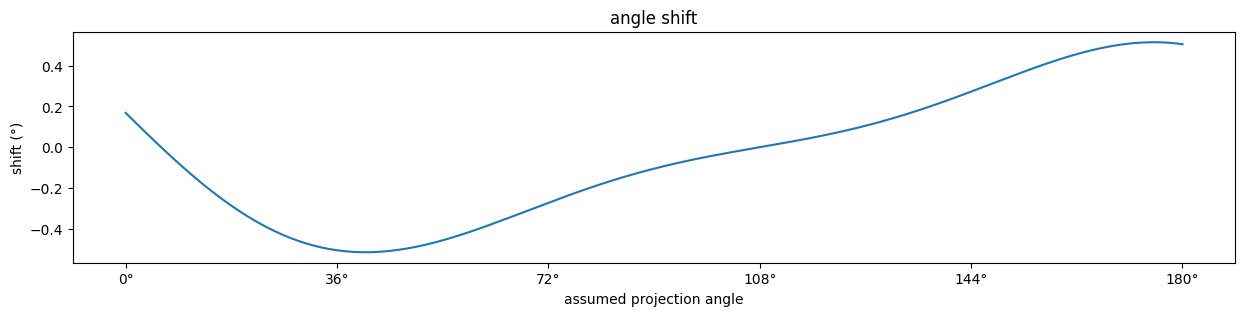

In [4]:
# The parameters for the distortion curve
amplitude = 0.01
frequency = 2
phase = 0.3 * np.pi

shift = amplitude * np.cos(assumed_angles * frequency + phase) + 0.005 * np.cos(assumed_angles * 3 + 0.7 * np.pi)
true_angles = assumed_angles + shift

# Plot the distortion
plt.figure(figsize=(15, 3))
plt.plot(assumed_angles * 180 / np.pi, shift * 180 / np.pi)
plt.xlabel('assumed projection angle')
plt.ylabel('shift (°)')
plt.title('angle shift')

tick_locs = np.linspace(0, 180, 6)
tick_labels = [f'{i:.0f}°' for i in tick_locs]
plt.xticks(tick_locs, tick_labels)
plt.show()

### True angles vs assumed angles

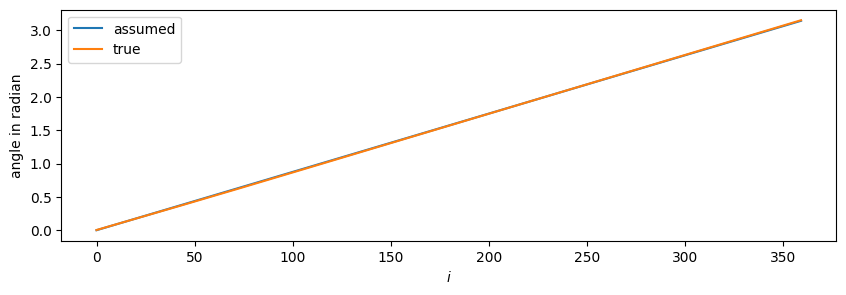

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(assumed_angles, label='assumed')
plt.plot(true_angles, label='true')

plt.xlabel('$i$')
plt.ylabel('angle in radian')

_ = plt.legend()

## Generate a phantom image and its corresponding sinogram with true angles

Text(0.5, 1.0, 'sinogram')

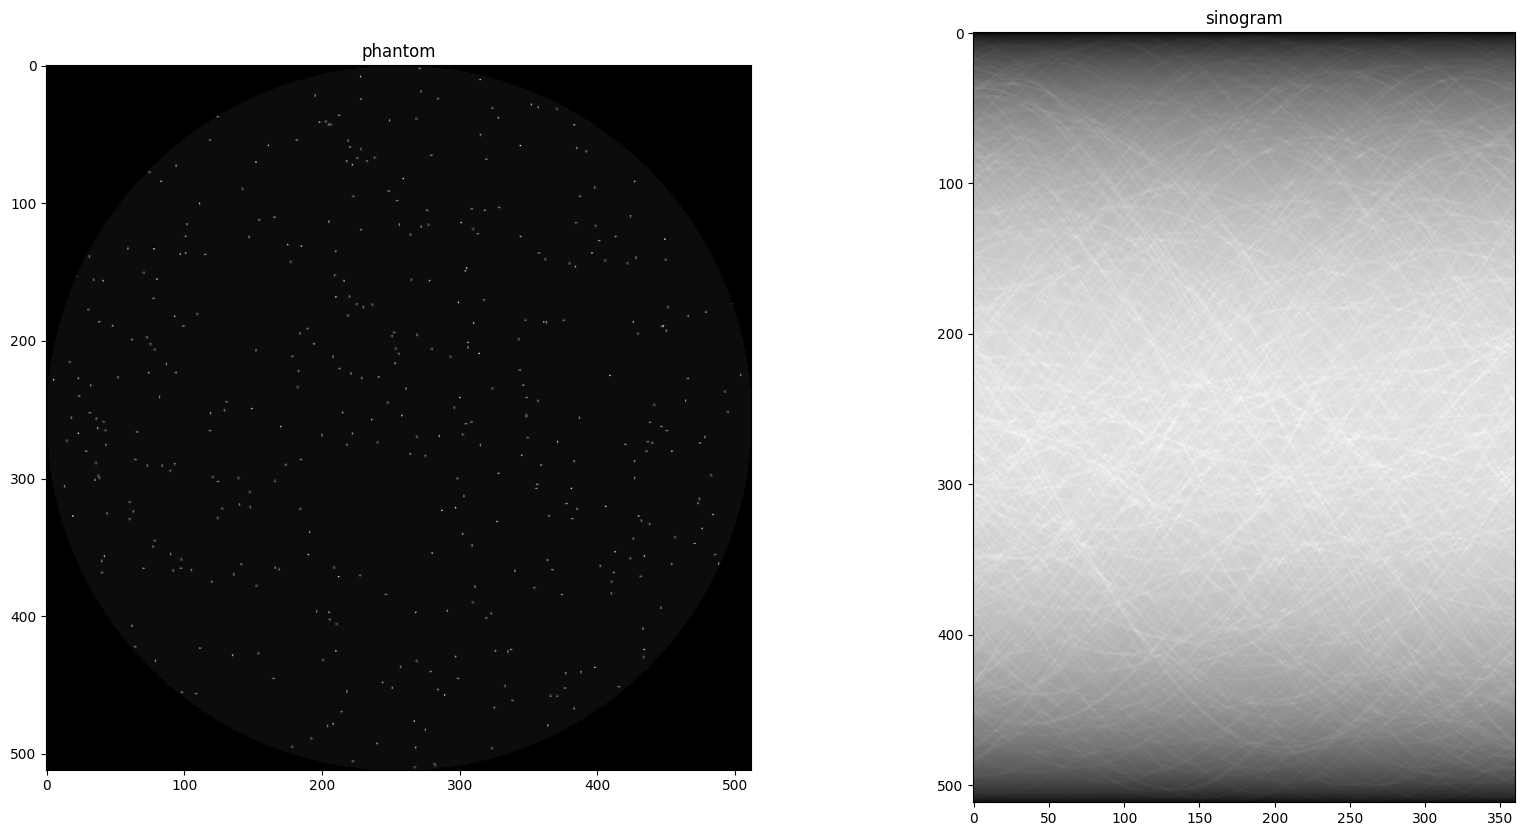

In [6]:
random_dots = np.random.uniform(0, min(*phantom_size), number_dots*2).reshape(2, -1)

phantom = get_phantom(phantom_size, random_dots, background)
sinogram = radon(phantom, true_angles / np.pi * 180)    # (phantom_size, number_projection)

# plot the phantom and the sinogram
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(phantom, cmap='gray')
axes[0].set_title('phantom')

axes[1].imshow(sinogram, cmap='gray')
axes[1].set_title('sinogram')

## Reconstruct the phantom with the assumed projection angles

Text(0.5, 1.0, 'reconstruction with assumed angles')

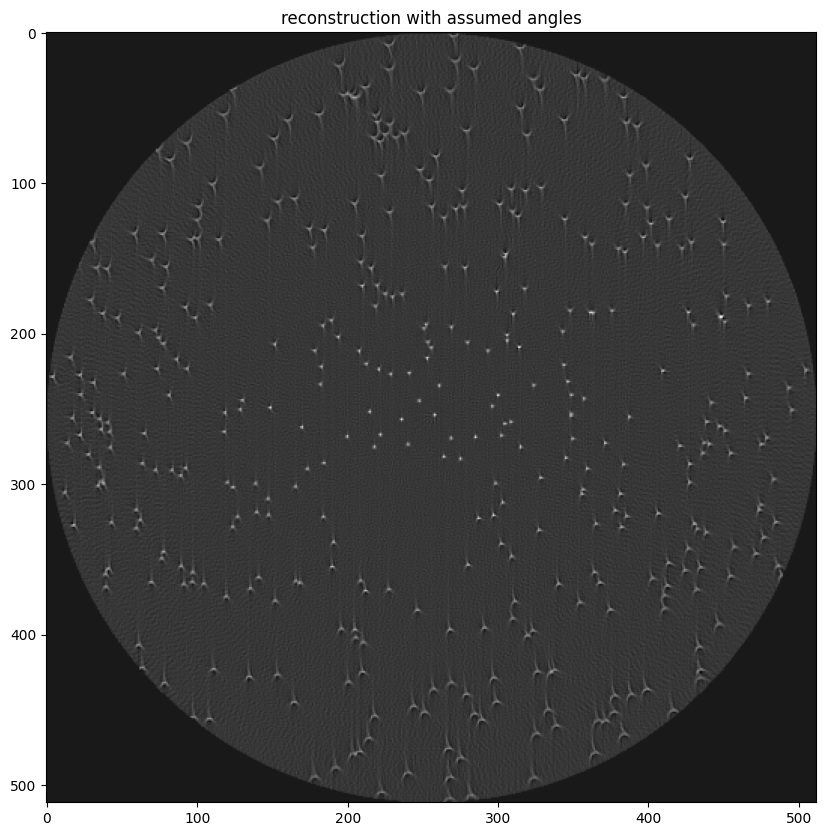

In [7]:
tampered_reconstructed = iradon(sinogram, assumed_angles / np.pi * 180, filter_name='ramp')

plt.figure(figsize=(10, 10))
plt.imshow(tampered_reconstructed, cmap='gray')
plt.title('reconstruction with assumed angles')

## Reconstruct the phantom with the true projection angles

Text(0.5, 1.0, 'reconstruction with true angles')

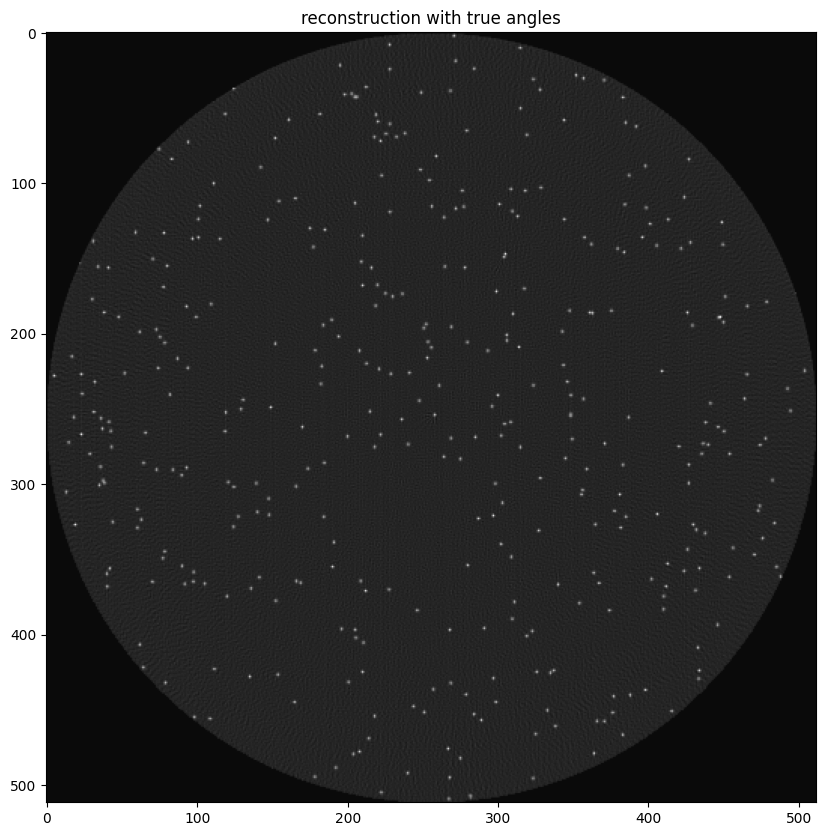

In [9]:
true_reconstructed = iradon(sinogram, true_angles / np.pi * 180, filter_name='ramp')

plt.figure(figsize=(10, 10))
plt.imshow(true_reconstructed, cmap='gray')
plt.title('reconstruction with true angles')

## Baysian optimization

In [15]:
theta, center = theta_correction(sinogram.T, np.linspace(0, np.pi, 360), 8, (0, 0), (-1, 1), init_points=30, n_iter=100) # find center
theta, center = theta_correction(sinogram.T, np.linspace(0, np.pi, 360), 8, (-0.015, 0.015), (center[0] - sinogram.shape[0] / 2, center[0] - sinogram.shape[0] / 2), init_points=50, n_iter=300) # find theta

|   iter    |  target   |  center0  |  theta0   |  theta1   |  theta2   |  theta3   |  theta4   |  theta5   |  theta6   |  theta7   |
-------------------------------------------------------------------------------------------------------------------------------------
| 3         | -0.03921  | 0.5362    | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       |
| 16        | -0.0392   | 0.5005    | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       | 0.0       |
|   iter    |  target   |  center0  |  theta0   |  theta1   |  theta2   |  theta3   |  theta4   |  theta5   |  theta6   |  theta7   |
-------------------------------------------------------------------------------------------------------------------------------------
| 11        | -0.03921  | 0.5005    | -0.002811 | -0.0102   | -0.01421  | -0.0103   | -0.007174 | 0.0003851 | 0.01402   | 0.008644  |
| 58        | -0.03902  | 0.5005    | 0.005348  | -0.01265  | 

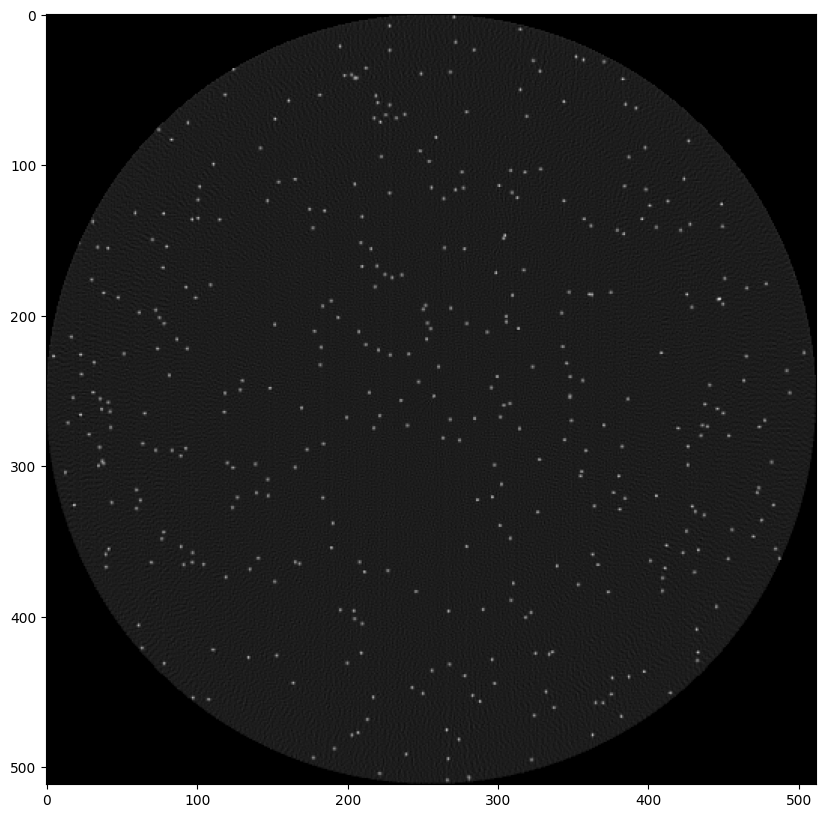

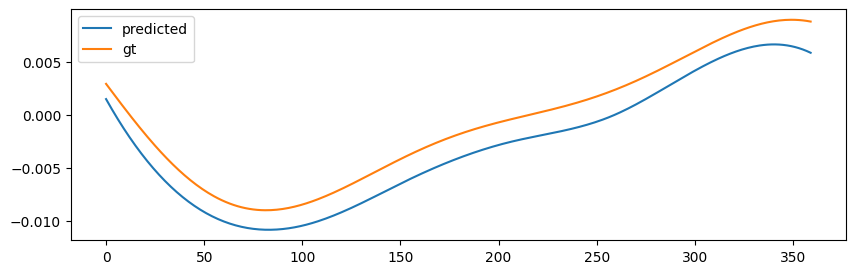

In [16]:
n_angles = sinogram.shape[-1]

recon = tomopy.recon(sinogram.T[:, np.newaxis, :],
                 theta,
                 center=center,
                 algorithm=tomopy.astra,
                 options={'proj_type': 'cuda', 'method': 'FBP_CUDA'},
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=1.0, val=0)[0]

plt.figure(figsize=(10, 10))
plt.imshow(recon, cmap='gray')

plt.figure(figsize=(10, 3))
plt.plot(theta - np.linspace(0, np.pi, n_angles), label='predicted')
plt.plot(shift, label='gt')
plt.legend()

In [20]:
real_sino = np.load('./data/sinogram.npy')

In [21]:
real_sino.shape

(600, 2560)

In [28]:
_, center = theta_correction(real_sino, np.linspace(0, np.pi, 600), 4, (0, 0), (-1, 1), 50, 150) # find center

|   iter    |  target   |  center0  |  theta0   |  theta1   |  theta2   |  theta3   |
-------------------------------------------------------------------------------------
| 2         | -0.000317 | 0.3406    | 0.0       | 0.0       | 0.0       | 0.0       |
| 15        | -0.000317 | 0.5293    | 0.0       | 0.0       | 0.0       | 0.0       |
| 17        | -0.000317 | 0.3694    | 0.0       | 0.0       | 0.0       | 0.0       |
| 28        | -0.000317 | 0.4224    | 0.0       | 0.0       | 0.0       | 0.0       |
| 75        | -0.000317 | 0.4122    | 0.0       | 0.0       | 0.0       | 0.0       |


In [32]:
center -= real_sino.shape[1] / 2
theta, center = theta_correction(real_sino, np.linspace(0, np.pi, 600), 10, (-0.02, 0.02), (center[0], center[0]), 100, 500) # find theta

|   iter    |  target   |  center0  |  theta0   |  theta1   |  theta2   |  theta3   |  theta4   |  theta5   |  theta6   |  theta7   |  theta8   |  theta9   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 105       | -0.000317 | 0.4122    | 0.01691   | 0.00617   | 0.009711  | 0.008393  | 0.006344  | 0.0181    | 0.01133   | -0.002295 | 0.004902  | 0.02      |
| 112       | -0.000317 | 0.4122    | 0.009058  | 0.00572   | 0.00829   | 0.009127  | 0.005848  | 0.02      | 0.016     | 0.006243  | 0.009984  | 0.02      |
| 131       | -0.000316 | 0.4122    | 0.01355   | 0.005711  | 0.01019   | 0.009327  | 0.007128  | 0.02      | 0.01495   | 0.005062  | 0.01069   | 0.009255  |
| 139       | -0.000316 | 0.4122    | 0.008685  | 0.005469  | 0.009367  | 0.009611  | 0.007498  | 0.02      | 0.01612   | 0.009452  | 0.007804  | 0.008273  |
| 146       | -0.000316 | 0.4122    | 0.008187  | 0.

In [33]:
center

array([1280.41215303])

In [38]:
theta.shape

(600,)

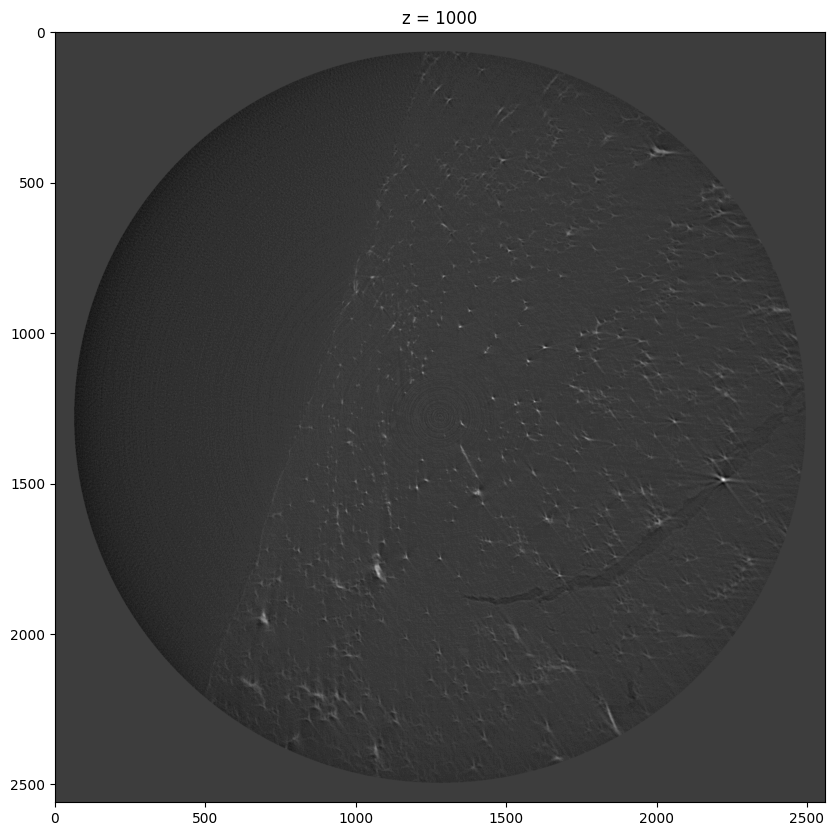

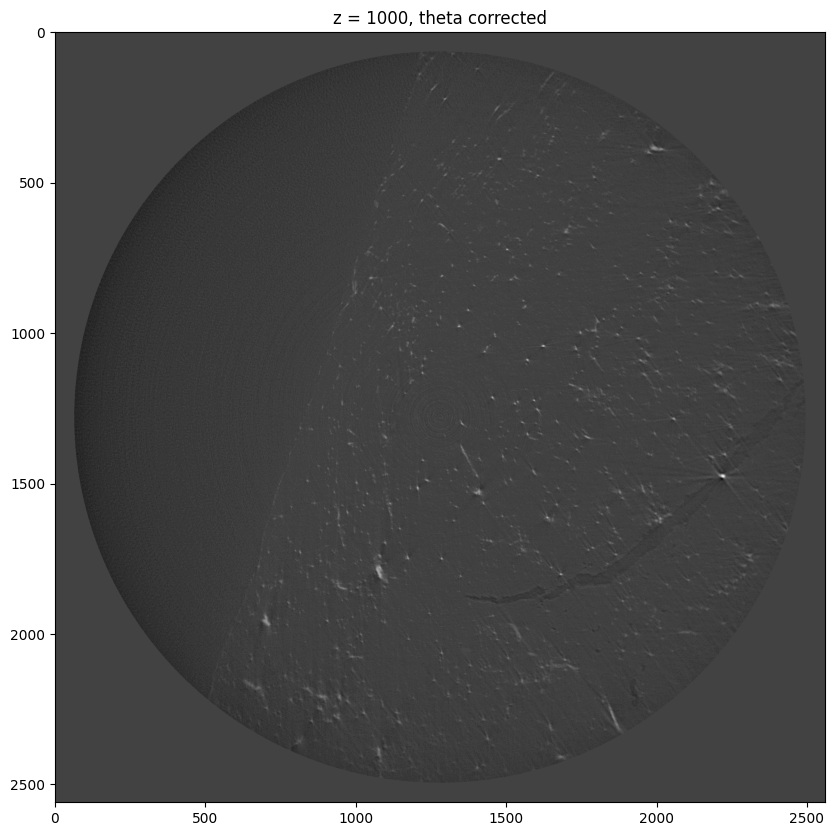

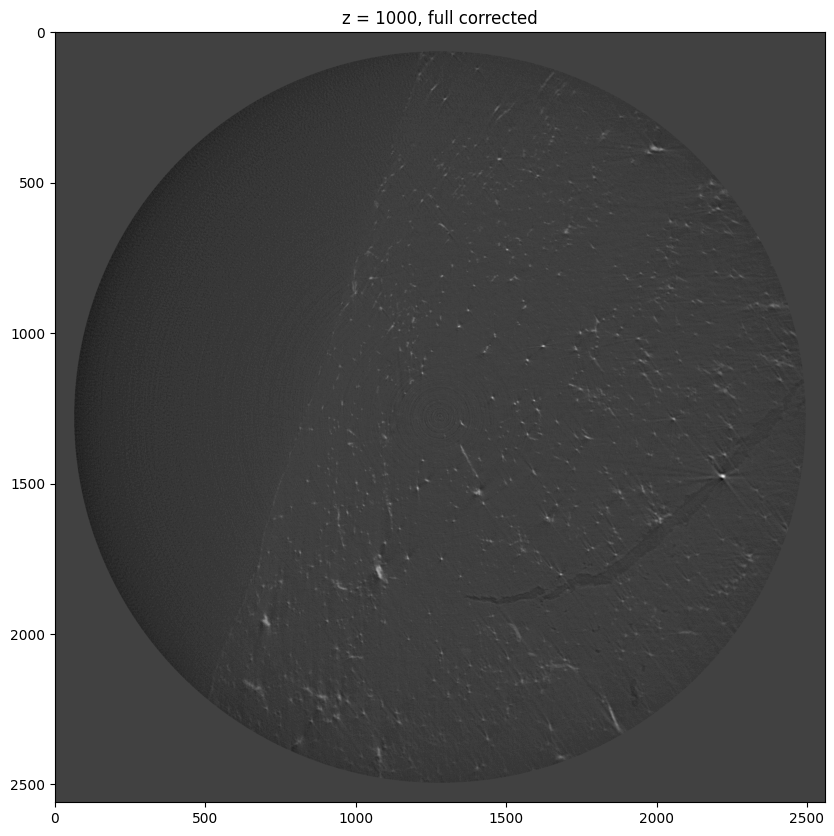

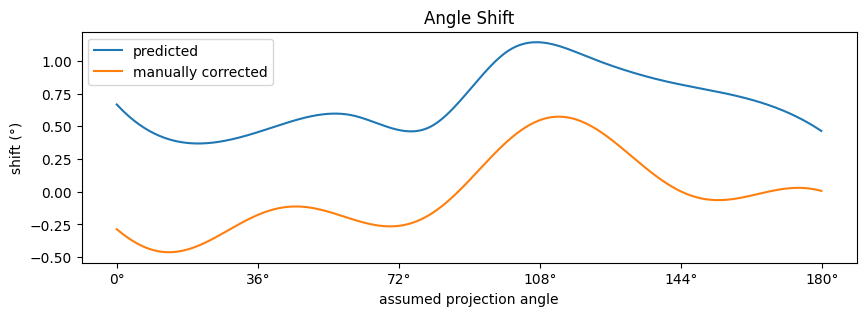

In [35]:
recon = tomopy.recon(real_sino[:, np.newaxis, :],
                 np.linspace(0, np.pi, 600),
                 center=None,
                 algorithm=tomopy.astra,
                 options={'proj_type': 'cuda', 'method': 'FBP_CUDA'},
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)[0]

plt.figure(figsize=(10, 10))
plt.title('z = 1000')
plt.imshow(recon, cmap='binary')

recon = tomopy.recon(real_sino[:, np.newaxis, :],
                 theta,
                 center=None,
                 algorithm=tomopy.astra,
                 options={'proj_type': 'cuda', 'method': 'FBP_CUDA'},
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)[0]

plt.figure(figsize=(10, 10))
plt.title('z = 1000, theta corrected')
plt.imshow(recon, cmap='binary')

recon = tomopy.recon(real_sino[:, np.newaxis, :],
                 theta,
                 center=center,
                 algorithm=tomopy.astra,
                 options={'proj_type': 'cuda', 'method': 'FBP_CUDA'},
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)[0]

plt.figure(figsize=(10, 10))
plt.title('z = 1000, full corrected')
plt.imshow(recon, cmap='binary')

shift = 0.0039 * np.cos(theta * 5.2 + 2.36) + 0.0063 * np.cos(theta * 2.1 + 1.88)

plt.figure(figsize=(10, 3))
plt.title('Angle Shift')
plt.plot((theta - np.linspace(0, np.pi, 600)) / np.pi * 180, label='predicted')
plt.plot(shift / np.pi * 180, label='manually corrected')
plt.legend()

plt.xlabel('assumed projection angle')
plt.ylabel('shift (°)')

tick_locs = np.linspace(0, 600, 6)
tick_labels = [f'{i / 600 * 180:.0f}°' for i in tick_locs]
plt.xticks(tick_locs, tick_labels)
plt.show()

In [36]:
import matplotlib.image
matplotlib.image.imsave('figs/corrected_1000.png', recon, cmap='binary')

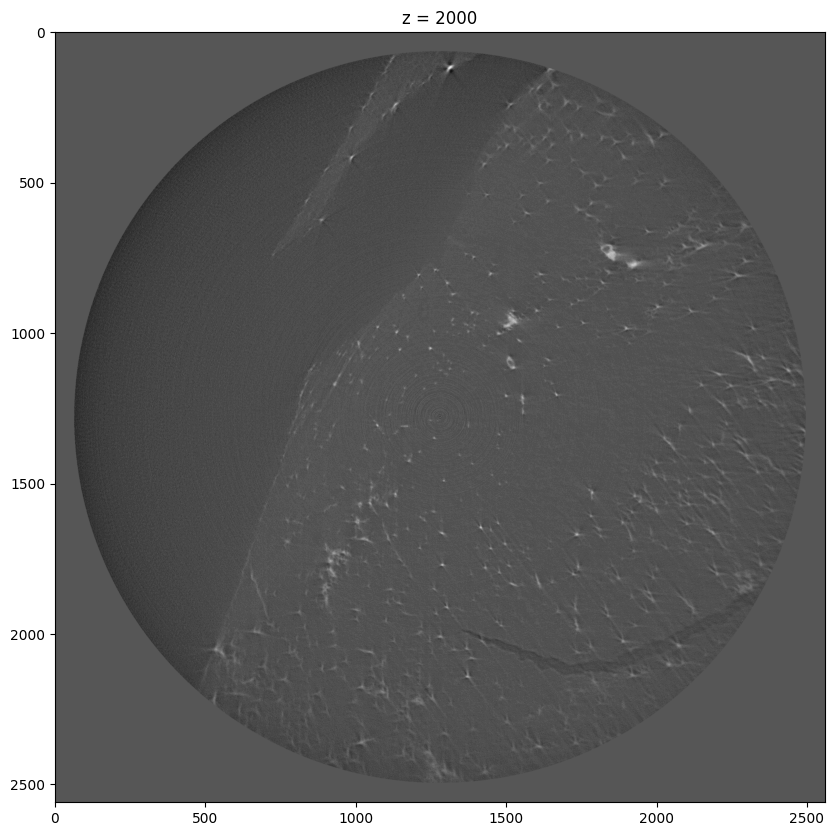

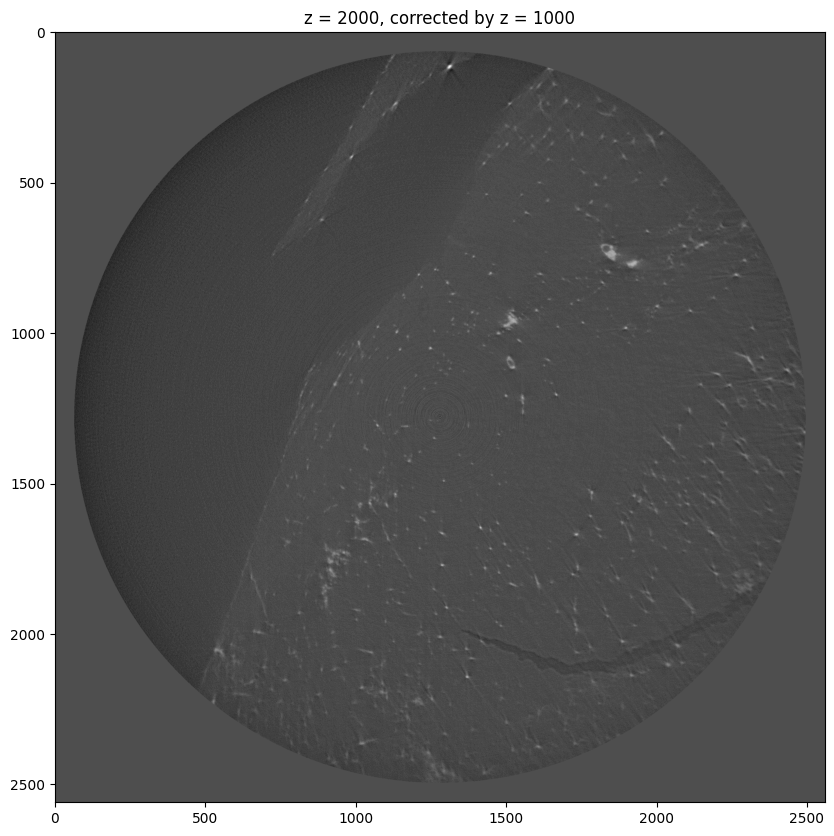

In [93]:
sino2000 = np.load('sinogram2000.npy')

recon = tomopy.recon(sino2000[:, np.newaxis, :],
                 np.linspace(0, np.pi, 600),
                 center=None,
                 algorithm=tomopy.astra,
                 options=options,
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)[0]

plt.figure(figsize=(10, 10))
plt.title('z = 2000')
plt.imshow(recon, cmap='binary')

matplotlib.image.imsave('assumed_recon.png', recon, cmap='binary')

recon = tomopy.recon(sino2000[:, np.newaxis, :],
                 theta,
                 center=None,
                 algorithm=tomopy.astra,
                 options=options,
                 ncore=1)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)[0]

plt.figure(figsize=(10, 10))
plt.title('z = 2000, corrected by z = 1000')
plt.imshow(recon, cmap='binary')

matplotlib.image.imsave('cor_recon.png', recon, cmap='binary')